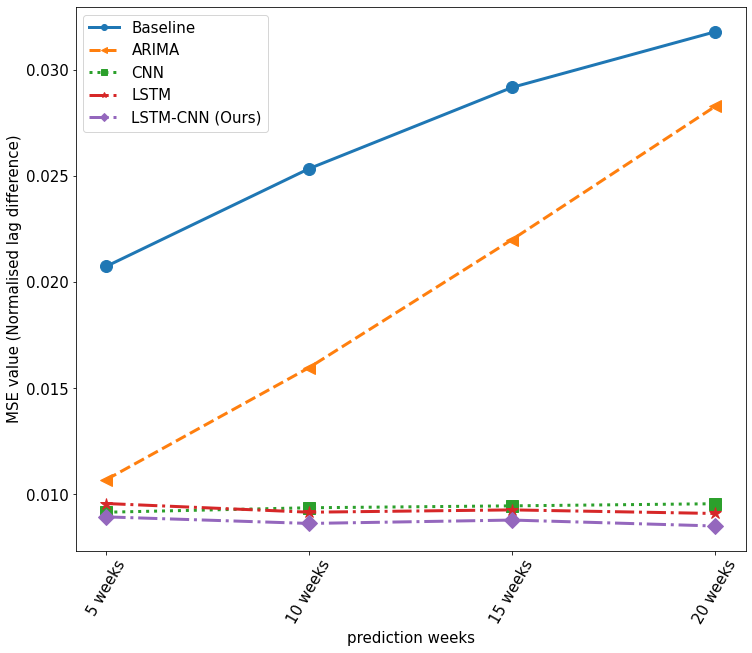

In [83]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rc('font', size=15) 
baseline = np.array([0.02076,0.02537, 0.0292, 0.03182])
arima = np.array([0.0107, 0.015986, 0.022023,0.0283])
cnn= np.array([0.00916,0.00937, 0.00946, 0.00956])
lstm = np.array([0.00957, 0.00916,0.00927, 0.00910])
lstm_cnn = np.array([0.00894, 0.00863, 0.00879, 0.00851]) 

plt.plot(baseline,linestyle='-', marker = 'o', markersize=12, linewidth=3)
plt.plot(arima,linestyle='--', marker = '<',  markersize=12, linewidth=3)
plt.plot(cnn, linestyle=':',marker = 's', markersize=12, linewidth=3)
plt.plot(lstm,linestyle='-.',  marker = '*', markersize=12, linewidth=3)
plt.plot(lstm_cnn, linestyle = '-.', marker = 'D', markersize=12,linewidth=3)               
#labels = ['5 weeks', '10 weeks', '15 weeks', '20 weeks']
ax.set_xticks(range(4))
ax.set_xticklabels(['5 weeks', '10 weeks', '15 weeks', '20 weeks'],rotation=60, fontsize=15)
plt.legend(["Baseline", "ARIMA", "CNN", "LSTM", "LSTM-CNN (Ours)"], loc ="upper left", markerscale = 0.5, fontsize=15)

plt.title('')
plt.xlabel('prediction weeks')
plt.ylabel('MSE value (Normalised lag difference)')

plt.savefig('Figure/multistep_mse.png', dpi=600,bbox_inches = "tight")
plt.show()

### mse error for each price

In [3]:
import pandas as pd
import tensorflow as tf
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)

from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statistics import mean

import IPython
import IPython.display

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_csv ('Data/weekly_features.csv')
df = df.drop (columns = ['Unnamed: 0','USD_PHP Historical Data.csv'])
dates = df.year*100+df.week
df['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
mask = (df['Date'] >'1990-09-30') & (df['Date'] <= '2021-09-30')
df= df.loc[mask]
df = df.fillna(method='ffill')

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.to_datetime().timetuple())

# https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/
# difference dataset
diff_df=df.drop(columns=['Date', 'year', 'week'])
diff_df = diff_df.diff()
diff_df = diff_df.iloc[1:]
#diff_df['year']=df.year[1:]
diff_df['week']=df.week[1:]
#diff_df['Date']=df.Date[1:]
#diff_df['Date'] = pd.to_datetime(diff_df['Date'])
# convert date to timestamp
#diff_df['Date'] = diff_df['Date'].map(pd.Timestamp.timestamp)

#split the data into training and testing dataset
column_indices = {name: i for i, name in enumerate(diff_df.columns)}

n = len(diff_df)
train_df = diff_df[0:int(n*0.7)]
test_df = diff_df[int(n*0.7):]

num_features = diff_df.shape[1]

#Normalize the data
from sklearn.preprocessing import MinMaxScaler
#col_list = [i for i in diff_df.columns if i != 'Date']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

In [58]:
raw_values = df.drop(columns = ['Date'])
raw_values = raw_values.reindex(columns=['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','week'])
test_raw_values = raw_values.loc[1185:]

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [36]:
five_step = []
ten_step = []
fifteen_step = []
twenty_step = []

In [99]:
past_history = 20
future_target = 15
STEP = 1
batch_size = 32
X_multi, y_multi = multivariate_data(scaled_train, scaled_train, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)

X_test_multi, y_test_multi = multivariate_data(scaled_test, scaled_test, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
test_data_multi= tf.data.Dataset.from_tensor_slices((X_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(batch_size).repeat()

multi_val_performance = {}
multi_test_performance = {}

In [100]:
multi_lstm_cnn = tf.keras.Sequential([
    tf.keras.layers.LSTM(224,input_shape= (past_history,num_features), return_sequences=True),
    tf.keras.layers.Dropout(rate = 0.55),
    tf.keras.layers.LSTM(96,input_shape= (past_history,num_features), return_sequences=True),
    tf.keras.layers.Dropout(rate = 0.15),
    #tf.keras.layers.LSTM(160,return_sequences=True),
    #tf.keras.layers.Dropout(rate = 0.45),
    tf.keras.layers.Conv1D(filters=224, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Dropout(rate = 0.65),
    #tf.keras.layers.Conv1D(filters=96, kernel_size=3, activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=1),
    #tf.keras.layers.Dropout(rate = 0.45),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(448, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(rate = 0.15),
    tf.keras.layers.Dense(future_target*num_features, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([future_target, num_features]) 

])
multi_lstm_cnn.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.MeanSquaredError()])
history = multi_lstm_cnn.fit(X_multi, y_multi, batch_size=batch_size, epochs=80)
yhat = multi_lstm_cnn.predict(X_test_multi)

Epoch 1/80
35/35 [==============================] - 6s 75ms/step - loss: 0.1171 - mean_squared_error: 0.1166
Epoch 2/80
35/35 [==============================] - 3s 81ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 3/80
35/35 [==============================] - 3s 83ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 4/80
35/35 [==============================] - 3s 78ms/step - loss: 0.0166 - mean_squared_error: 0.0167
Epoch 5/80
35/35 [==============================] - 3s 79ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 6/80
35/35 [==============================] - 3s 77ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 7/80
35/35 [==============================] - 2s 68ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 8/80
35/35 [==============================] - 3s 80ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 9/80
35/35 [==============================] - 3s 84ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 10/80
35/35 [

35/35 [==============================] - 3s 79ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 76/80
35/35 [==============================] - 3s 81ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 77/80
35/35 [==============================] - 3s 86ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 78/80
35/35 [==============================] - 3s 80ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 79/80
35/35 [==============================] - 3s 77ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 80/80
15/15 [==============================] - 1s 32ms/step


In [48]:

for i in [5,6,7,8]:
    mse = mean_squared_error(y_test_multi[:,:,i], yhat[:,:,i])
    twenty_step.append(mse)

Epoch 1/80
35/35 [==============================] - 7s 82ms/step - loss: 0.1695 - mean_squared_error: 0.1680
Epoch 2/80
35/35 [==============================] - 3s 82ms/step - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 3/80
35/35 [==============================] - 3s 79ms/step - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 4/80
35/35 [==============================] - 3s 83ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 5/80
35/35 [==============================] - 2s 68ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 6/80
35/35 [==============================] - 3s 84ms/step - loss: 0.0165 - mean_squared_error: 0.0165
Epoch 7/80
35/35 [==============================] - 3s 80ms/step - loss: 0.0161 - mean_squared_error: 0.0162
Epoch 8/80
35/35 [==============================] - 3s 81ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 9/80
35/35 [==============================] - 3s 74ms/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 10/80
35/35 [

35/35 [==============================] - 3s 78ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 76/80
35/35 [==============================] - 3s 82ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 77/80
35/35 [==============================] - 2s 67ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 78/80
35/35 [==============================] - 2s 70ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 79/80
35/35 [==============================] - 2s 68ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 80/80
15/15 [==============================] - 1s 17ms/step


In [101]:
mse_15 = []
mse_steps = []
for i in range(X_test_multi.shape[0]):  
    yhat = multi_lstm_cnn.predict(X_test_multi[i:i+1,:,:])
    yhat=yhat[0,:,:]
    yhat = scaler.inverse_transform(yhat)
    initial = test_df.iloc[i:i+future_target].index.values[0]
    #previous = raw_values.loc[initial-1:initial-1+future_target-1].values
    #yhat_inverse_diff = yhat + previous
    ytrue = test_df.loc[initial:initial+future_target-1].values
    for j in [5,6,7,8]:
        mse = mean_squared_error(ytrue[:,j],yhat[:,j])
        mse_steps.append(mse)
mse_steps = np.array(mse_steps)
mse_steps = mse_steps.reshape(X_test_multi.shape[0],4)
mse_15 = mse_steps.mean(axis = 0)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 3ms/step


In [93]:
mse_5

array([151.62554824, 226.20049892, 763.83935338, 291.77679346])

In [94]:
mse_20

array([154.79123287, 217.02517178, 746.27810826, 268.35243649])

In [98]:
mse_10

array([152.68546706, 222.08418584, 764.76195499, 278.5962326 ])

In [102]:
mse_15

array([154.7822019 , 222.54554897, 762.18495348, 278.42561096])

In [49]:
mse_grain=np.stack((five_step,ten_step,fifteen_step,twenty_step))

In [50]:
mse_grain = pd.DataFrame(mse_grain, columns=['Oats','Corn','Soybeans','Wheat'])

In [85]:
five_step

[0.014313787967626335,
 0.0064302725626071405,
 0.009111950801120674,
 0.005279886632307223]

In [35]:
twenty_step

NameError: name 'twenty_step' is not defined

In [51]:
mse_grain.to_csv('Data/mse_grain.csv')

In [4]:
mse_grain = pd.read_csv('Data/mse_grain.csv')

In [52]:
mse_grain

,Oats,Corn,Soybeans,Wheat
0,0.014644,0.006770,0.009428,0.005279
1,0.014364,0.006408,0.008984,0.005229
2,0.014296,0.006419,0.009255,0.005199
3,0.014145,0.006151,0.008747,0.005079


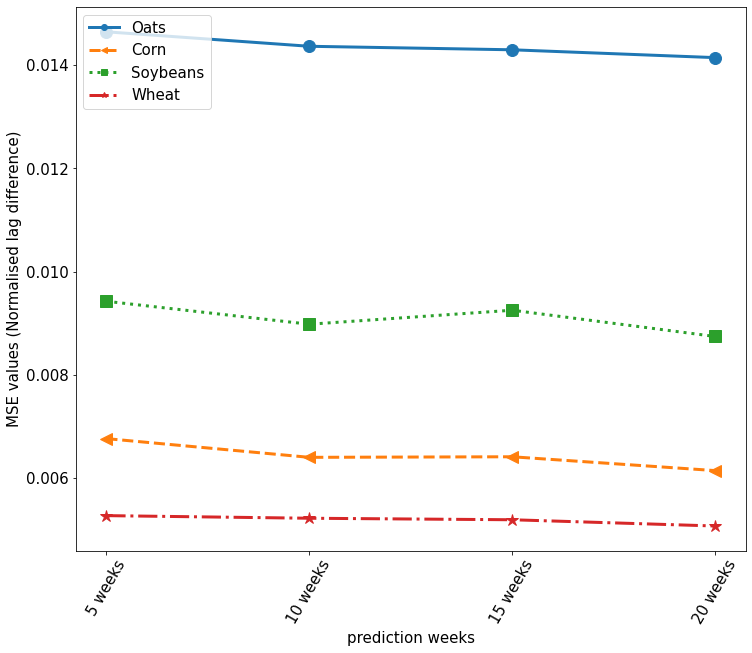

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rc('font', size=15) 

plt.plot(mse_grain['Oats'],linestyle='-', marker = 'o', markersize=12, linewidth=3)
plt.plot(mse_grain['Corn'],linestyle='--', marker = '<',  markersize=12, linewidth=3)
plt.plot(mse_grain['Soybeans'], linestyle=':',marker = 's', markersize=12, linewidth=3)
plt.plot(mse_grain['Wheat'],linestyle='-.',  marker = '*', markersize=12, linewidth=3)             
#labels = ['5 steps', '10 steps', '15 steps', '20 steps']
ax.set_xticks(range(4))
ax.set_xticklabels(['5 weeks', '10 weeks', '15 weeks', '20 weeks'],rotation=60, fontsize=15)
plt.legend(['Oats','Corn','Soybeans','Wheat'], loc ="upper left", markerscale = 0.5, fontsize=15)

plt.title('')
plt.xlabel('prediction weeks')
plt.ylabel('MSE values (Normalised lag difference)')

plt.savefig('Figure/mse_grain.png',dpi=600,bbox_inches = "tight")
plt.show()

### plot prediction examples

1/1 [==============================] - 0s 19ms/step


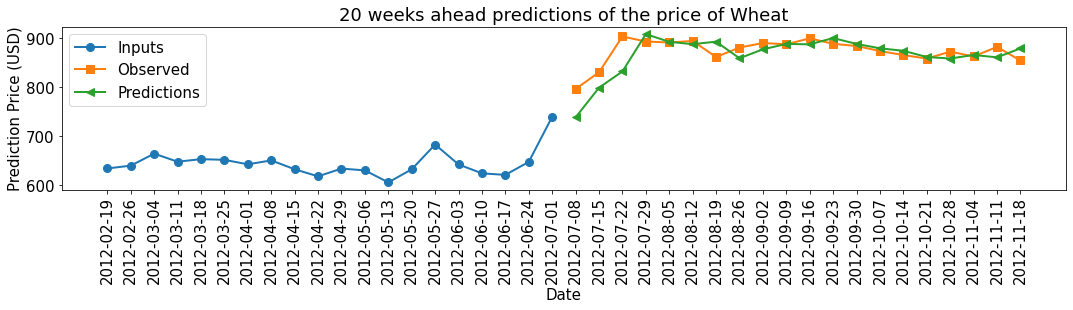

In [30]:
a = plot(X_test_multi,multi_lstm_cnn,3,8)
plt.savefig('Figure/prediction_3_wheat.png',bbox_inches = "tight",dpi=600)

In [15]:
def plot(x_test,model,sample_point=1, columns_index=1):
    yhat = model.predict(x_test[sample_point:sample_point+1,:,:])
    yhat=yhat[0,:,:]
    yhat = scaler.inverse_transform(yhat)
    initial = test_df.iloc[sample_point:sample_point+future_target].index.values[0]
    previous = raw_values.loc[initial-1:initial-1+future_target-1].values
    yhat_inverse_diff = yhat + previous
    ytrue = raw_values.loc[initial:initial+future_target-1].values
    column_name = raw_values.columns[columns_index]
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 3))
    #input value
    plt.plot(df.loc[initial-future_target:initial-1]['Date'], raw_values.loc[initial-future_target:initial-1][column_name].values,linestyle='-', marker = 'o', markersize=8, linewidth=2)
    #true value
    plt.plot(df.loc[initial:initial+future_target-1]['Date'],ytrue[:,columns_index],marker = 's', markersize=8, linewidth=2)
    #prediction value
    plt.plot(df.loc[initial:initial+future_target-1]['Date'],yhat_inverse_diff[:,columns_index] ,marker = '<', markersize=8, linewidth=2)
    ax.set_xticks(range(40))
    labels = df.loc[initial-past_history:initial+future_target-1]['Date']
    ax.set_xticklabels(labels, rotation = 'vertical')
    
    plt.legend(["Inputs", "Observed", "Predictions"], loc ="upper left", markerscale = 1, fontsize=15)
    plt.xlabel('Date')
    plt.ylabel('Prediction Price (USD)')
    plt.title('20 weeks ahead predictions of the price of '+column_name)
